# Tutorial: One Machine against Infinite Bus (OMIB)

This tutorial will introduce you to the functionality of `LITS` for running Power System Simulations.
Note that this tutorial is for `LITS 0.3.5`. Future versions will have dedicated functions to find an equilibrium point using a Power Flow method without relying in a guess of the initial condition to run a non-linear solver.

This tutorial presents a simulation of a two-bus system, with an infinite bus (represented as a voltage source behind an impedance) at bus 1 and a classic machine on bus 2. The perturbation will be the trip of one of the two circuits (doubling its resistance and impedance) of the line that connects both buses.

This tutorial can be found on [LITS/Examples](https://github.com/Energy-MAC/LITS-Examples) repository.

## Step 1: Package Initialization

The first step consists in initialize all packages that will be used to run the simulation. All the necessary packages are listed. Please note that loading the packages may take some time.

In [1]:
] up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating git-repo `https://github.com/Energy-MAC/LITS.jl.git`
 Resolving package versions...
 Installed PowerSystems ─ v0.17.0
  Updating `~/.julia/dev/LITS-Examples/Project.toml`
  [86b0dc02] ↑ LITS v0.3.0 #master (https://github.com/Energy-MAC/LITS.jl.git) ⇒ v0.3.5 #master (https://github.com/Energy-MAC/LITS.jl.git)
  [91a5bcdd] ↑ Plots v0.28.4 ⇒ v1.2.0
  [bcd98974] ↑ PowerSystems v0.9.0 ⇒ v0.17.0
  [c3572dad] ↑ Sundials v3.8.2 ⇒ v4.2.1
  Updating `~/.julia/dev/LITS-Examples/Manifest.toml`
  [1520ce14] + AbstractTrees v0.3.3
  [4fba245c] ↑ ArrayInterface v2.4.1 ⇒ v2.8.7
  [9e28174c] ↑ BinDeps v1.0.0 ⇒ v1.0.1
  [b99e7846] ↑ BinaryProvider v0.5.8 ⇒ v0.5.9
  [a74b3585] ↑ Blosc v0.5.1 ⇒ v0.6.0
  [6e34b625] + Bzip2_jll v1.0.6+2
  [fa961155] + CEnum v0.2.0
  [631607c0] ↑ CMake v1.1.2 ⇒ v1.2.0
  [336ed68f] ↑ CSV v0.5.23 ⇒ v0.6.1
  [d360d2e6] ↑ ChainRulesCore v0.6.1 ⇒ v

In [2]:
using LITS
using PowerSystems
using Sundials
using NLsolve
using Plots

┌ Info: Precompiling LITS [86b0dc02-7903-11e9-325f-f195ca7e6c1a]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


`PowerSystems` is used to properly define the data structure, while `Sundials` is used to solve the problem defined in `LITS`.

## Step 2: Data creation

### We are still improving the data management with a closer integration within `PowerSystems.jl`

Next we need to define the different elements required to run a simulation. To run a simulation, it is required to define a `System` from `PowerSystems.jl`

- A base static System, we will parse it from a PSS/e raw file
- Add a Source to the Ref (Slack) Bus
- Add the dynamic data to the static data sets. 

In [5]:
omib_file_dir= joinpath(dirname(@__FILE__), "Data","OMIB.raw")
omib_sys = System(PowerModelsData(omib_file_dir), runchecks=false)

┌ Info: The PSS(R)E parser currently supports buses, loads, shunts, generators, branches, transformers, and dc lines
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/y1jmI/src/parsers/pm_io/common.jl:26
┌ Info: Constructing System from Power Models
│   data["name"] = omib
│   data["source_type"] = pti
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/y1jmI/src/parsers/power_models_data.jl:39
┌ Info: Reading bus data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/y1jmI/src/parsers/power_models_data.jl:140
┌ Info: Reading generator data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/y1jmI/src/parsers/power_models_data.jl:386
┌ Info: Reading branch data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/y1jmI/src/parsers/power_models_data.jl:538
┌ Info: Reading branch data
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/y1jmI/src/parsers/power_models_data.jl:601
┌ Info: Reading DC Line data
└ @ Pow

,ConcreteType,SuperTypes,Count
,String,String,Int64
1,Area,AggregationTopology <: Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
2,Bus,Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,2
3,Line,ACBranch <: Branch <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
4,LoadZone,AggregationTopology <: Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
5,PowerLoad,StaticLoad <: ElectricLoad <: StaticInjection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
6,ThermalStandard,ThermalGen <: Generator <: StaticInjection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1


In [6]:
# get_components is designed to return fast Julia iterators. For this application we need to run collect to retrieve 
# the bus
slack_bus = collect(get_components(Bus, omib_sys, b -> b.bustype == BusTypes.REF))[1]
inf_source = Source(
    name = "InfBus", #name
    available = true, #availability
    activepower = 0.0,
    reactivepower = 0.0,
    bus = slack_bus, #bus
    X_th = 0.000005 #Xth
) 
add_component!(omib_sys, inf_source)

We can now run a PowerFlow to initialize the system voltages and static generator values.

In [7]:
res = solve_powerflow!(omib_sys, nlsolve)

┌ Info: Results of Nonlinear Solver Algorithm
│  * Algorithm: Trust-region with dogleg and autoscaling
│  * Starting Point: [0.0, 0.0, 0.0, 0.0]
│  * Zero: [-0.19831111106230975, -0.3604466665495688, 0.3778709112379719, 0.006192283580558579]
│  * Inf-norm of residuals: 0.000000
│  * Iterations: 2
│  * Convergence: true
│    * |x - x'| < 0.0e+00: false
│    * |f(x)| < 1.0e-08: true
│  * Function Calls (f): 3
│  * Jacobian Calls (df/dx): 3
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/y1jmI/src/utils/power_flow/power_flow.jl:145
┌ Info: PowerFlow solve converged, the results have been stored in the system
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/y1jmI/src/utils/power_flow/power_flow.jl:148


true

### Dynamic Injection devices

Note that a generator is defined by its 5 components, while also defining its reference for frequency, voltage and power. The reactive power reference must be defined but is not used for standard machines, since is only used for PQ generators, that will be implemented in future versions of `LITS`.

In [8]:
function dyn_gen_first_order(generator)
    return DynamicGenerator(
        number = 1, 
        name = "Case1Gen",
        bus = get_bus(generator),
        ω_ref = 1.0, 
        V_ref = get_voltage(get_bus(generator)),
        P_ref = get_activepower(generator),
        Q_ref = get_reactivepower(generator),
        machine = machine_OMIB = BaseMachine(
                                            0.0, #R
                                            0.2995, #Xd_p
                                            1.1409, #eq_p
                                            100.0, #MVABase,
                                            ),  
        shaft =SingleMass(
                          3.148, #H
                          2.0, #D
                          ), 
        avr = AVRFixed(0.0), 
        prime_mover = TGFixed(1.0), #No TG: Efficiency = 1.0
        pss = PSSFixed(0.0) #No PSS without AVR,
    )
end

#Attach dynamic generator. Currently use PSS/e format based on bus #.
gen = [g for g in get_components(Generator, omib_sys)][1]
case_gen = dyn_gen_first_order(gen)
add_component!(omib_sys, case_gen)

Note that in here `eq_p` is fixed and defined manually. This parameter eventually will be updated accordingly to match the power flow solution in future releases of `LITS`.

## Step 3: Build the simulation and initializing the problem

The next step is to create the simulation structure. This will create the indexing of our system that will be used to formulate the differential-algebraic system of equations. To do so, it is required to specify the perturbation that will occur in the system. `LITS` support two types of perturbations:
- Three Phase Fault
- Change in Reference Parameter

In here, he will use a Three Phase Fault, that is modeled by modifying the admittance matrix of the system. To do so we create a ThreePhaseFault perturbation as follows:

In [9]:
#Obtain the Ybus of the faulted system by modifying the branch that will have the fault. 
fault_branch = deepcopy(collect(get_components(Branch, omib_sys))[1])
fault_branch.r = 0.02; fault_branch.x = 0.1
Ybus_fault = Ybus([fault_branch], get_components(Bus, omib_sys))[:, :]

#Construct the perturbation
perturbation_Ybus = ThreePhaseFault(
    1.0, #change will occur at t = 1.0s
    Ybus_fault, #new Ybus
);

With this, we are ready to create our simulation structure. We will skip solving for initial conditions to discuss about indexing. To construct our simulation we use:

In [10]:
#Define Simulation
sim = Simulation(
    omib_sys, #system
    (0.0, 30.0), #time span
    perturbation_Ybus, #Type of perturbation
    initialize_simulation = false #keyword argument to not find initial conditions.
)

Simulation()


This will create the simulation structure that will be used to run the transient simulation and will modify the system to include the indexing. `LITS` will have the following structure for the vector of variables:

Instatiating the simulation will correctly initialize the system. If no initial guess is provided, the system will use a flat start guess, assuming that all real voltages are equal to one, while imaginary voltages are equal to zero. Differential variables (states) will be guessed as zero too.

In [11]:
# Initial condition obtained with a flat start
sim.x0_init 

6-element Array{Float64,1}:
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0

However, for most systems if a bad initial guess is used, the non-linear solver may fail in correctly initializing the system. For such purposes, an initial guess can be provided to the simulation as follows:

In [12]:
#Initial guess
x0_guess = [
    1.0, #VR_1
    1.0, #VR_2
    0.0, #VI_1
    0.0, #VI_2
    0.2, #δ
    1.0, #ω
]
#Define Simulation
sim = Simulation(
    omib_sys, #system
    (0.0, 30.0), #time span
    perturbation_Ybus, #Type of perturbation
    initial_guess = x0_guess, #initial guess
)

sim.x0_init

┌ Info: Initializing Simulation States
└ @ LITS /Users/rhenriquez/.julia/packages/LITS/MSVav/src/base/simulation.jl:32


6-element Array{Float64,1}:
 1.000001805317657   
 1.0198928686905258  
 9.314434263707981e-7
 0.00570973037889138 
 0.13468423041852054 
 1.0                 

## Step 4: Run the Simulation

Finally, to run the simulation we simply use:

In [13]:
#Solve problem
run_simulation!(sim, #simulation structure
                IDA(), #Sundials DAE Solver
                dtmax=0.02); #Arguments: Maximum timestep allowed

In some cases, the dynamic time step used for the simulation may fail. In such case, the keyword argument `dtmax` can be used to limit the maximum time step allowed for the simulation.

## Step 5: Exploring the solution

After running the simulation, our simulation structure `sim` will have the solution. `LITS` has two functions to obtain different states of the solution:

- ``get_state_series(sim, ("OMIB_Gen", :δ))``: can be used to obtain the solution as a tuple of time and the required state. In this case, we are obtaining the rotor angle `:δ` of the generator named `"OMIB_Gen"`.
- ``get_voltagemag_series(sim, 2)``: can be used to obtain the voltage magnitude as a tuple of time and voltage. In this case, we are obtaining the voltage magnitude at bus 2 (where the generator is located).

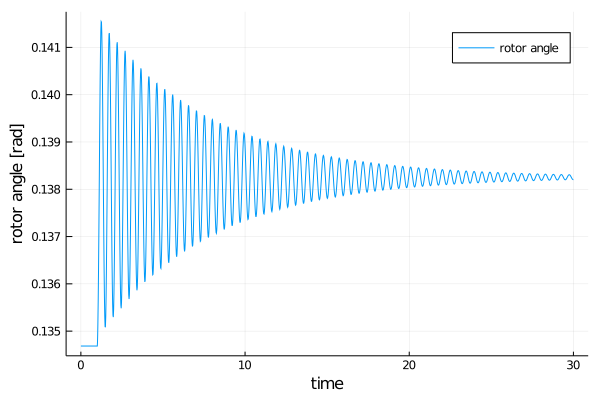

In [14]:
angle = get_state_series(sim, ("Case1Gen", :δ))
plot(angle, xlabel="time", ylabel="rotor angle [rad]", label="rotor angle")

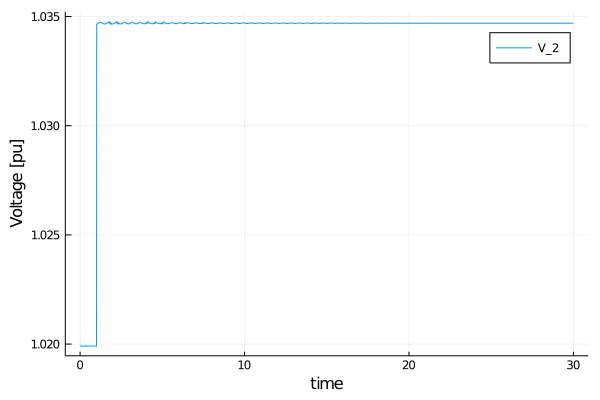

In [15]:
volt = get_voltagemag_series(sim, 2)
plot(volt, xlabel="time", ylabel="Voltage [pu]", label="V_2")

## Optional: Small Signal Analysis

`LITS 0.3.5` uses automatic differentiation to compute the reduced Jacobian of the system for the differential states. This can be used to analyze the eigenvalues of the linearized system.

In [16]:
small_sig = small_signal_analysis(sim)

The system is small signal stable


The `small_sig` result can report the reduced jacobian for $\delta$ and $\omega$, and can also be used to report the eigenvalues of the reduced linearized system.

In [17]:
small_sig.reduced_jacobian

2×2 Array{Float64,2}:
  0.0       376.991   
 -0.439168   -0.317662

In [18]:
small_sig.eigenvalues

2-element Array{Complex{Float64},1}:
 -0.15883100381194404 - 12.866119096482956im
 -0.15883100381194404 + 12.866119096482956im